# Dicoding Time series with LSTM Submission

## New York City Taxi Trip - Hourly Weather Data
## source : Kaggle
## link to dataset : https://www.kaggle.com/meinertsen/new-york-city-taxi-trip-hourly-weather-data

### 10.400 samples

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
#function to transform numpy type to batch (from dicoding )
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [3]:
#New York City Taxi Trip - Hourly Weather Data
weather = pd.read_csv('/content/Weather.csv') 
weather.head()

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,wdird,wdire,vism,visi,pressurem,pressurei,windchillm,windchilli,heatindexm,heatindexi,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2015-12-31 00:15:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,40,NE,4.0,2.5,1018.2,30.07,6.6,43.9,NaN,NaN,0.5,0.02,Light Rain,rain,0,1,0,0,0,0
1,2015-12-31 00:42:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,0,Variable,6.4,4.0,1017.8,30.06,6.6,43.9,NaN,NaN,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
2,2015-12-31 00:51:00,7.8,46.0,6.1,43.0,89.0,5.6,3.5,NaN,NaN,20,NNE,8.0,5.0,1017.0,30.04,7.1,44.8,NaN,NaN,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
3,2015-12-31 01:51:00,7.2,45.0,5.6,42.1,90.0,7.4,4.6,NaN,NaN,0,Variable,12.9,8.0,1016.5,30.02,5.9,42.6,NaN,NaN,0.3,0.01,Overcast,cloudy,0,0,0,0,0,0
4,2015-12-31 02:51:00,7.2,45.0,5.6,42.1,90.0,0.0,0.0,NaN,NaN,0,North,12.9,8.0,1016.7,30.03,NaN,NaN,NaN,NaN,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


In [4]:
#pick 2 columns to be used
#tempm and datetime
weather = weather[['pickup_datetime', 'tempm']]
weather.head()

,pickup_datetime,tempm
0,2015-12-31 00:15:00,7.8
1,2015-12-31 00:42:00,7.8
2,2015-12-31 00:51:00,7.8
3,2015-12-31 01:51:00,7.2
4,2015-12-31 02:51:00,7.2


In [5]:
weather.dropna(subset=['tempm'], inplace=True) #drop any NAN
weather.isnull().sum() #check

pickup_datetime    0
tempm              0
dtype: int64

In [6]:
weather.shape #check data shape

(10476, 2)

In [7]:
weather['pickup_datetime'] = pd.to_datetime(weather['pickup_datetime']) #set datetime dtypes 
weather.dtypes

pickup_datetime    datetime64[ns]
tempm                     float64
dtype: object

In [8]:
weather = weather.set_index(['pickup_datetime']) #set datetime as index

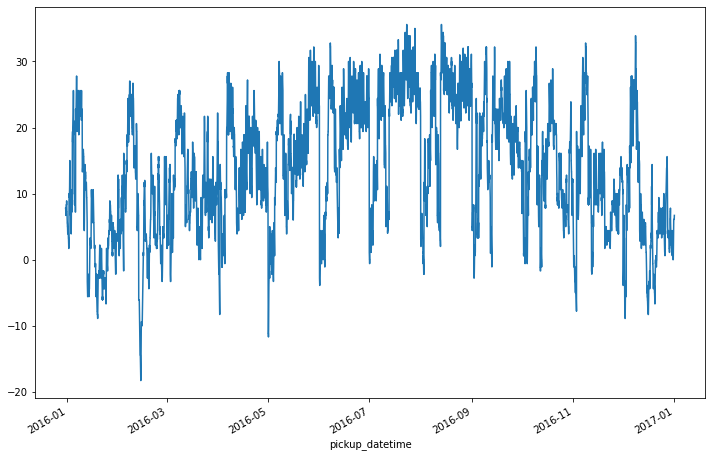

In [9]:
plt.figure(figsize=(12, 8))
weather['tempm'].plot.line()
plt.show()

In [10]:
#set target MAE
target_MAE = (weather['tempm'].max() - weather['tempm'].min()) * (10/100)
target_MAE

5.390000000000001

In [11]:
#pick the train set
train = weather[['tempm']] #temperature

In [12]:
#train validation split
#shuffle false because timeseries data is sensitive to shuffling
X_train, X_valid = train_test_split(train, test_size=0.2, shuffle=False, random_state=42)

In [13]:
#transform data from numpy type to batch
train_set = windowed_dataset(X_train, 64, 256, 1000)
val_set = windowed_dataset(X_valid, 64, 256, 1000)

In [14]:
model = keras.Sequential([
  layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  layers.LSTM(64, return_sequences=True),
  layers.LSTM(64, return_sequences=True),
  layers.Dense(30, activation="relu"),
  layers.Dense(10, activation="relu"),
  layers.Dense(1),
  layers.Lambda(lambda x: x * 400)
])


In [15]:
#i actually dont understand learning rate, because dicoding havent explain it yet
#but dicoding requires it so i use their learning rate model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9) 
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [16]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae')< target_MAE):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
early_stop = myCallback()

In [17]:
#train the model
tf.keras.backend.set_floatx('float64')
history = model.fit(train_set,
                    epochs=500, 
                    validation_data=val_set, 
                    callbacks=[early_stop])

Epoch 1/500
33/33 [==============================] - 17s 401ms/step - loss: 37.9572 - mae: 38.4567 - val_loss: 33.4379 - val_mae: 33.9373
Epoch 2/500
33/33 [==============================] - 13s 375ms/step - loss: 34.7464 - mae: 35.2457 - val_loss: 30.6305 - val_mae: 31.1297
Epoch 3/500
33/33 [==============================] - 12s 372ms/step - loss: 31.4785 - mae: 31.9778 - val_loss: 27.9315 - val_mae: 28.4304
Epoch 4/500
33/33 [==============================] - 12s 372ms/step - loss: 28.3842 - mae: 28.8832 - val_loss: 25.3386 - val_mae: 25.8367
Epoch 5/500
33/33 [==============================] - 13s 374ms/step - loss: 25.4117 - mae: 25.9104 - val_loss: 22.8312 - val_mae: 23.3289
Epoch 6/500
33/33 [==============================] - 12s 369ms/step - loss: 22.5295 - mae: 23.0280 - val_loss: 20.4000 - val_mae: 20.8971
Epoch 7/500
33/33 [==============================] - 13s 376ms/step - loss: 19.7309 - mae: 20.2286 - val_loss: 18.1094 - val_mae: 18.6027
Epoch 8/500
33/33 [===============

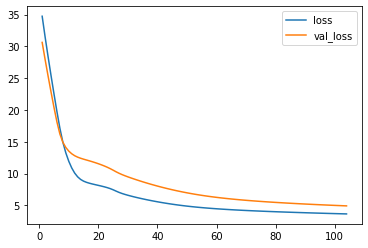

In [18]:
#loss
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
plt.show()

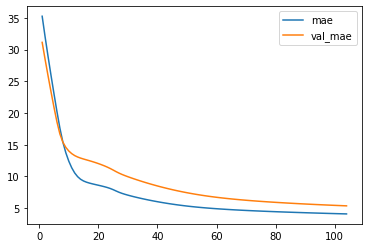

In [19]:
#accuracy 
history_df.loc[1:, ['mae', 'val_mae']].plot()
plt.show()

In [20]:
#Best validation loss and validation mae score
print(("Best Validation Loss: {:0.2f}" +"\nBest Validation MAE: {:0.2f}").format(history_df['val_loss'].min(), history_df['val_mae'].min()))

Best Validation Loss: 4.91
Best Validation MAE: 5.37
